<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Polynomial Regression


Estimated time needed: **15** minutes
    

## Objectives

After completing this lab you will be able to:

* Use scikit-learn to implement Polynomial Regression
* Create a model, train it, test it and use the model


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#download_data">Downloading Data</a></li>
        <li><a href="#polynomial_regression">Polynomial regression</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


### Importing Needed packages


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline


<h2 id="download_data">Downloading Data</h2>
To download the data, we will use !wget to download it from IBM Object Storage.


In [10]:
#!wget -O FuelConsumption.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv

__Did you know?__ When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](https://www.ibm.com/us-en/cloud/object-storage?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork)



## Understanding the Data

### `FuelConsumption.csv`:
We have downloaded a fuel consumption dataset, **`FuelConsumption.csv`**, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. [Dataset source](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)

- **MODELYEAR** e.g. 2014
- **MAKE** e.g. Acura
- **MODEL** e.g. ILX
- **VEHICLE CLASS** e.g. SUV
- **ENGINE SIZE** e.g. 4.7
- **CYLINDERS** e.g 6
- **TRANSMISSION** e.g. A6
- **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
- **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 8.9
- **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
- **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0


## Reading the data in


In [11]:
df = pd.read_csv("FuelConsumptionCo2.csv")

# take a look at the dataset
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


Let's select some features that we want to use for regression.


In [12]:
cdf = df[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
cdf.head(9)

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_COMB,CO2EMISSIONS
0,2.0,4,8.5,196
1,2.4,4,9.6,221
2,1.5,4,5.9,136
3,3.5,6,11.1,255
4,3.5,6,10.6,244
5,3.5,6,10.0,230
6,3.5,6,10.1,232
7,3.7,6,11.1,255
8,3.7,6,11.6,267


Let's plot Emission values with respect to Engine size:


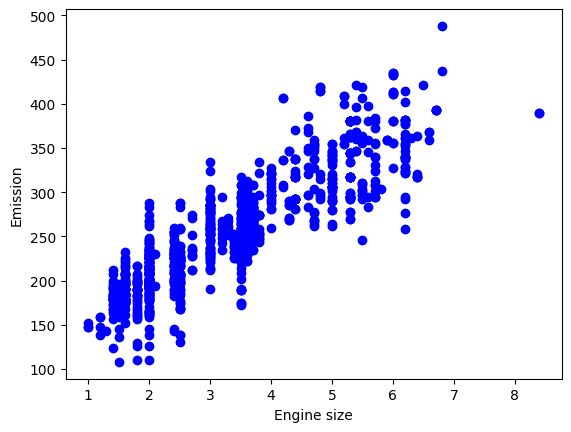

In [13]:
plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

#### Creating train and test dataset
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set.


In [14]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

<h2 id="polynomial_regression">Polynomial regression</h2>


Sometimes, the trend of data is not really linear, and looks curvy. In this case we can use Polynomial regression methods. In fact, many different regressions exist that can be used to fit whatever the dataset looks like, such as quadratic, cubic, and so on, and it can go on and on to infinite degrees.

In essence, we can call all of these, polynomial regression, where the relationship between the independent variable x and the dependent variable y is modeled as an nth degree polynomial in x. Lets say you want to have a polynomial regression (let's make 2 degree polynomial):


$$y = b + \theta_1  x + \theta_2 x^2$$



Now, the question is: how we can fit our data on this equation while we have only x values, such as __Engine Size__? 
Well, we can create a few additional features: 1, $x$, and $x^2$.



__PolynomialFeatures()__ function in Scikit-learn library, drives a new feature sets from the original feature set. That is, a matrix will be generated consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, lets say the original feature set has only one feature, _ENGINESIZE_. Now, if we select the degree of the polynomial to be 2, then it generates 3 features, degree=0, degree=1 and degree=2: 


In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
train_x = np.asanyarray(train[['ENGINESIZE']])
train_y = np.asanyarray(train[['CO2EMISSIONS']])

test_x = np.asanyarray(test[['ENGINESIZE']])
test_y = np.asanyarray(test[['CO2EMISSIONS']])


poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(train_x)
train_x_poly

array([[ 1.  ,  2.  ,  4.  ],
       [ 1.  ,  2.4 ,  5.76],
       [ 1.  ,  1.5 ,  2.25],
       ...,
       [ 1.  ,  3.  ,  9.  ],
       [ 1.  ,  3.2 , 10.24],
       [ 1.  ,  3.2 , 10.24]])

**fit_transform** takes our x values, and output a list of our data raised from power of 0 to power of 2 (since we set the degree of our polynomial to 2).   

The equation and the sample example is displayed below.   


$$
\begin{bmatrix}
    v_1\\\\\\
    v_2\\\\
    \vdots\\\\
    v_n
\end{bmatrix}\longrightarrow \begin{bmatrix}
    [ 1 & v_1 & v_1^2]\\\\
    [ 1 & v_2 & v_2^2]\\\\
    \vdots & \vdots & \vdots\\\\
    [ 1 & v_n & v_n^2]
\end{bmatrix}
$$




$$
\begin{bmatrix}
    2.\\\\
    2.4\\\\
    1.5\\\\
    \vdots
\end{bmatrix} \longrightarrow \begin{bmatrix}
    [ 1 & 2. & 4.]\\\\
    [ 1 & 2.4 & 5.76]\\\\
    [ 1 & 1.5 & 2.25]\\\\
    \vdots & \vdots & \vdots\\\\
\end{bmatrix}
$$







It looks like feature sets for multiple linear regression analysis, right? Yes. It Does. 
Indeed, Polynomial regression is a special case of linear regression, with the main idea of how do you select your features. Just consider replacing the  $x$ with $x_1$, $x_1^2$ with $x_2$, and so on. Then the 2nd degree equation would be turn into:

$$y = b + \theta_1  x_1 + \theta_2 x_2$$

Now, we can deal with it as a 'linear regression' problem. Therefore, this polynomial regression is considered to be a special case of traditional multiple linear regression. So, you can use the same mechanism as linear regression to solve such problems. 



so we can use __LinearRegression()__ function to solve it:


In [16]:
clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[ 0.         51.60938105 -1.63542869]]
Intercept:  [105.43888092]


As mentioned before, __Coefficient__ and __Intercept__ , are the parameters of the fit curvy line. 
Given that it is a typical multiple linear regression, with 3 parameters, and knowing that the parameters are the intercept and coefficients of hyperplane, sklearn has estimated them from our new set of feature sets. Lets plot it:


Text(0, 0.5, 'Emission')

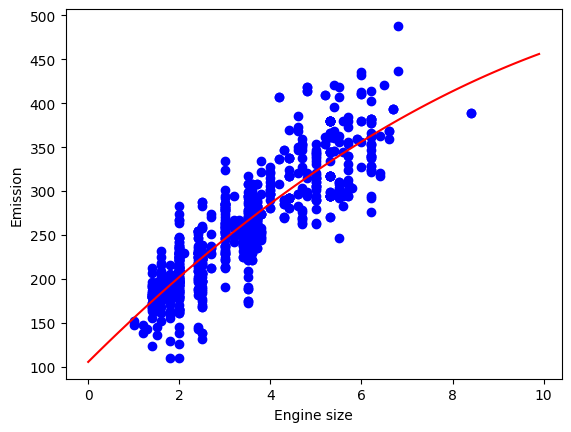

In [17]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
XX = np.arange(0.0, 10.0, 0.1)
yy = clf.intercept_[0]+ clf.coef_[0][1]*XX+ clf.coef_[0][2]*np.power(XX, 2)
plt.plot(XX, yy, '-r' )
plt.xlabel("Engine size")
plt.ylabel("Emission")

<h2 id="evaluation">Evaluation</h2>


In [18]:
from sklearn.metrics import r2_score

test_x_poly = poly.transform(test_x)
test_y_ = clf.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y,test_y_ ) )

Mean absolute error: 23.03
Residual sum of squares (MSE): 871.09
R2-score: 0.77


<h2 id="practice">Practice</h2>
Try to use a polynomial regression with the dataset but this time with degree three (cubic). Does it result in better accuracy?


In [19]:
# write your code here


<details><summary>Click here for the solution</summary>

```python    
poly3 = PolynomialFeatures(degree=3)
train_x_poly3 = poly3.fit_transform(train_x)
clf3 = linear_model.LinearRegression()
train_y3_ = clf3.fit(train_x_poly3, train_y)

# The coefficients
print ('Coefficients: ', clf3.coef_)
print ('Intercept: ',clf3.intercept_)
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
XX = np.arange(0.0, 10.0, 0.1)
yy = clf3.intercept_[0]+ clf3.coef_[0][1]*XX + clf3.coef_[0][2]*np.power(XX, 2) + clf3.coef_[0][3]*np.power(XX, 3)
plt.plot(XX, yy, '-r' )
plt.xlabel("Engine size")
plt.ylabel("Emission")
test_x_poly3 = poly3.transform(test_x)
test_y3_ = clf3.predict(test_x_poly3)
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y3_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y3_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y,test_y3_ ) )

```

</details>


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="https://www.ibm.com/analytics/spss-statistics-software?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://www.ibm.com/cloud/watson-studio?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork">Watson Studio</a>



### Thank you for completing this lab!


## Author

Saeed Aghabozorgi


### Other Contributors

<a href="https://www.linkedin.com/in/joseph-s-50398b136/" target="_blank">Joseph Santarcangelo</a>


## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>


<!--## Change Log


|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2021-01-11  | 2.3  | Lakshmi  |  Changed R2-score calculation in polynomial regression |
| 2020-11-04  | 2.2  | Lakshmi  |  Made changes in markdown of equations |
| 2020-11-03  | 2.1  | Lakshmi  |  Made changes in URL |
| 2020-08-27  | 2.0  | Lavanya  |  Moved lab to course repo in GitLab |
|   |   |   |   |
|   |   |   |   | --!>


